In [1]:
"""Data inspection. For HCP connectomes"""

'Data inspection. For HCP connectomes'

In [27]:
import csv
import functools
import importlib
import os

import matplotlib
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch

import analyze
importlib.reload(analyze)
import datasets
importlib.reload(datasets)
import vis
importlib.reload(vis)
import toylosses
importlib.reload(toylosses)
import nn
importlib.reload(nn)
import train_utils
importlib.reload(train_utils)

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")

In [150]:
from ray.tune.analysis import ExperimentAnalysis
analysis = ExperimentAnalysis("/home/nina/ray_results/Train")
print("Best config is", analysis.get_best_logdir(metric="average_loss_reconstruction", mode='min'))

Best config is /home/nina/ray_results/Train/Train_7_batch_size=4,inner_dim=256,latent_dim=5,logvar=-5.0,lr=1e-05,n_layers=4_2019-10-23_15-56-49y31wlfgz


In [151]:
OUTPUT = 'Train_7_batch_size=4,inner_dim=256,latent_dim=5,logvar=-5.0,lr=1e-05,n_layers=4_2019-10-23_15-56-49y31wlfgz'
print_criterion(OUTPUT, crit_name='neg_loglikelihood')

/home/nina/ray_results/Train/Train_7_batch_size=4,inner_dim=256,latent_dim=5,logvar=-5.0,lr=1e-05,n_layers=4_2019-10-23_15-56-49y31wlfgz/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_7_batch_size=4,inner_dim=256,latent_dim=5,logvar=-5.0,lr=1e-05,n_layers=4_2019-10-23_15-56-49y31wlfgz/checkpoint_64/epoch_64_checkpoint.pth.


-70.77923621200934

In [29]:
DATA_DIR = '/neuro/'
DATA_TYPE = 'conn'

IMG_SHAPE = (15, 15)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)
TRAIN_DATASET_PATH = os.path.join(
    DATA_DIR, 'train_val_datasets/%s_%s_%s.npy' % (
        'train', DATA_TYPE, SHAPE_STR))
VAL_DATASET_PATH = os.path.join(
    DATA_DIR, 'train_val_datasets/%s_%s_%s.npy' % (
        'val', DATA_TYPE, SHAPE_STR))

DATASET_PATH = TRAIN_DATASET_PATH
DATASET = np.load(DATASET_PATH)
# dataset, _ = datasets.get_dataset_connectomes(IMG_SHAPE)

CMAP = 'Spectral'



# Show original SPD data

Loading /neuro/train_val_datasets/train_conn_15x15.npy
Dataset shape: (771, 1, 15, 15)


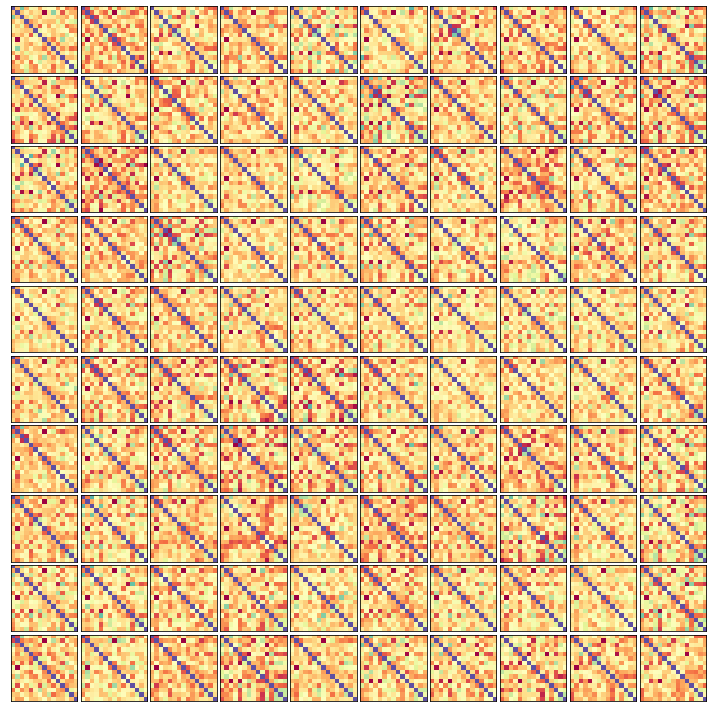

In [117]:
vis.show_data(DATASET_PATH, cmap=CMAP, nrows=10, ncols=10, figsize=(10, 10))
plt.subplots_adjust(hspace=0.051, wspace=0.05)

In [14]:
def load_checkpoint(train_dir):
    ckpt_path = os.path.join('/home/nina/ray_results/Train', train_dir, 'checkpoint_64', 'epoch_64_checkpoint.pth')
    print(ckpt_path)
    if not os.path.isfile(ckpt_path):
        print('No checkpoint 64 in %s' % train_dir)
        return
    print('Found checkpoint. Getting: %s.' % ckpt_path)
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    return ckpt

def load_losses(train_dir, crit_name='neg_loglikelihood', mode='val'):
    ckpt = load_checkpoint(train_dir)
    
    losses = ckpt['%s_losses' % mode]
    criteria = [loss[crit_name] for loss in losses]
    return criteria

def print_criterion(train_dir, crit_name='neg_loglikelihood', mode='val'):
    criteria = load_losses(train_dir, crit_name, mode)
    last_criterion = criteria[-1]
    return last_criterion

In [15]:
print_criterion(OUTPUT)

NameError: name 'OUTPUT' is not defined

/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth.
/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth.


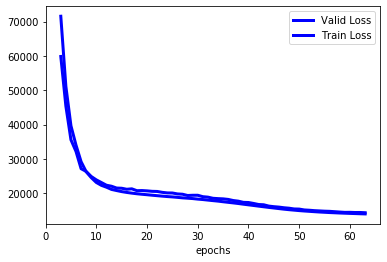

In [16]:
def plot_criterion(ax, train_dir, crit_name='neg_elbo',
                   mode='train', start_epoch_id=0, color='blue', dashes=False):
    epoch_id = 64
    losses_total = load_losses(train_dir, crit_name=crit_name, mode=mode)

    n_epochs = len(losses_total)
    epochs = range(n_epochs)
    if epoch_id is not None:
        epoch_id = min(epoch_id, n_epochs)

    label = '%s Loss' % (
        #ALGO_STRINGS[algo_name],
        vis.TRAIN_VAL_STRINGS[mode])
        #CRIT_STRINGS[crit_name])
    #label = '%s: %s %s' % (
    #    ALGO_STRINGS[algo_name],
    #    TRAIN_VAL_STRINGS[mode],
    #    CRIT_STRINGS[crit_name])

    if not dashes:
        ax.plot(
            epochs[start_epoch_id:epoch_id],
            losses_total[start_epoch_id:epoch_id],
            label=label, color=color, linewidth=3)
    else:
        ax.plot(
            epochs[start_epoch_id:epoch_id],
            losses_total[start_epoch_id:epoch_id],
            label=label, color=color, dashes=[2, 2, 2, 2], linewidth=3)
    ax.set_xlabel('epochs')
    ax.legend()
    return ax

fig = plt.figure()
ax = fig.add_subplot(111)
ax = plot_criterion(ax, train_dir, crit_name='neg_elbo', mode='val', start_epoch_id=3)
ax = plot_criterion(ax, train_dir, crit_name='neg_elbo', mode='train', start_epoch_id=3)

In [17]:
def plot_criterion_map(crit_name='neg_loglikelihood', mode='val'):
    inner_dims = []
    latent_dims = []
    crits = []
    for train_dir in os.listdir('/home/nina/ray_results/Train/'):
        last_ckpt_path = os.path.join('/home/nina/ray_results/Train', train_dir, 'checkpoint_64')
        if os.path.isdir(last_ckpt_path):
            split_list = train_dir.replace('=',' ').replace(',',' ').split()
            inner_dim = split_list[1]
            inner_dims.append(int(inner_dim))
            latent_dims.append(int(split_list[3]))
            crits.append(print_criterion(train_dir))
            
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.scatter(latent_dims, inner_dims)

    for i, txt in enumerate(crits):
        ax.annotate(round(txt, 6), (latent_dims[i], inner_dims[i]))
    ax.set_xlabel('Latent dim')
    ax.set_ylabel('Inner dim')
    print(len(crits))

/home/nina/ray_results/Train/Train_0_batch_size=4,inner_dim=256,latent_dim=2,logvar=-10.0,lr=1e-05,n_layers=4_2019-10-23_15-52-39x0qwjzql/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_0_batch_size=4,inner_dim=256,latent_dim=2,logvar=-10.0,lr=1e-05,n_layers=4_2019-10-23_15-52-39x0qwjzql/checkpoint_64/epoch_64_checkpoint.pth.
/home/nina/ray_results/Train/Train_2_inner_dim=256,latent_dim=2,logvar=-1.0,lr=1e-05,n_layers=4_2019-10-23_07-04-174s3m0dx5/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_2_inner_dim=256,latent_dim=2,logvar=-1.0,lr=1e-05,n_layers=4_2019-10-23_07-04-174s3m0dx5/checkpoint_64/epoch_64_checkpoint.pth.
/home/nina/ray_results/Train/Train_7_batch_size=4,inner_dim=256,latent_dim=5,logvar=-5.0,lr=1e-05,n_layers=4_2019-10-23_15-19-08xz6v1004/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_7_batch_size=4,inner_dim=256,la

/home/nina/ray_results/Train/Train_18_batch_size=16,inner_dim=32,latent_dim=2,logvar=-5.0,lr=1e-06,n_layers=4_2019-10-23_14-28-25ywx44n1w/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_18_batch_size=16,inner_dim=32,latent_dim=2,logvar=-5.0,lr=1e-06,n_layers=4_2019-10-23_14-28-25ywx44n1w/checkpoint_64/epoch_64_checkpoint.pth.
/home/nina/ray_results/Train/Train_319_inner_dim=128,latent_dim=5,logvar=-1.0,lr=0.001,n_layers=8_2019-10-23_08-26-25ln4tgakk/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_319_inner_dim=128,latent_dim=5,logvar=-1.0,lr=0.001,n_layers=8_2019-10-23_08-26-25ln4tgakk/checkpoint_64/epoch_64_checkpoint.pth.
/home/nina/ray_results/Train/Train_137_inner_dim=256,latent_dim=2,logvar=-1.0,lr=0.001,n_layers=8_2019-10-23_07-40-24is0uhmjv/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_137_inner_dim=256,latent_dim=2,logvar=

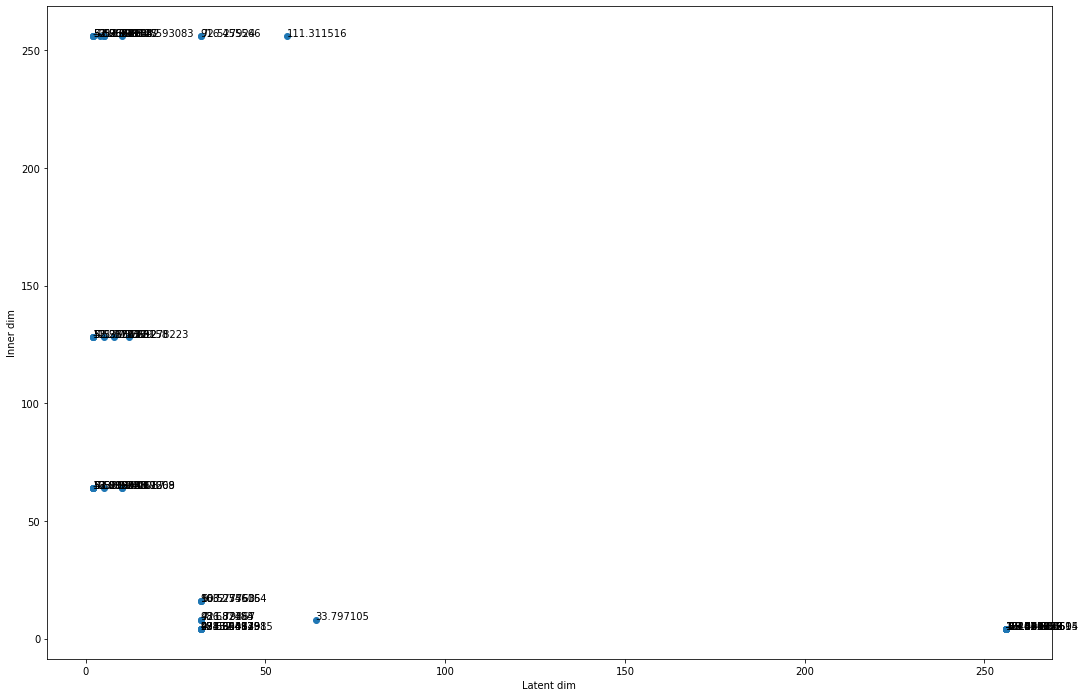

In [18]:
plot_criterion_map()

In [19]:
def get_hcp(labels_path):
    labels = {}
    labels['Gender'] = []
    labels['Age'] = []
    with open(labels_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for i_row, row in enumerate(reader):
            if i_row == 0:
                continue
            labels['Gender'].append(row[1])
            labels['Age'].append(row[2])

    return labels

In [20]:
labels = get_hcp('/neuro/train_val_datasets/hcp_labels.csv')

In [21]:
def load_module(train_dir, module_name):
    ckpt = load_checkpoint(train_dir)
    nn_architecture = ckpt['nn_architecture']

    nn_type = nn_architecture['nn_type']
    print('Loading %s from network of architecture: %s...' % (
        module_name, nn_type))
    assert nn_type in ['toy', 'fc', 'conv', 'conv_plus']

    if nn_type == 'toy':
        vae = toynn.VAE(
            latent_dim=nn_architecture['latent_dim'],
            data_dim=nn_architecture['data_dim'],
            n_layers=nn_architecture['n_decoder_layers'],
            nonlinearity=nn_architecture['nonlinearity'],
            with_biasx=nn_architecture['with_biasx'],
            with_logvarx=nn_architecture['with_logvarx'],
            with_biasz=nn_architecture['with_biasz'],
            with_logvarz=nn_architecture['with_logvarz'])
        vae.to(DEVICE)

    elif nn_type == 'fc':
        vae = nn.Vae(
            latent_dim=nn_architecture['latent_dim'],
            data_dim=nn_architecture['data_dim'],
            with_sigmoid=nn_architecture['with_sigmoid'],
            n_layers=nn_architecture['n_layers'],
            inner_dim=nn_architecture['inner_dim'],
            with_skip=nn_architecture['with_skip'],
            logvar=nn_architecture['logvar'])
    elif nn_type == 'conv':
        vae = nn.VaeConv(
            latent_dim=nn_architecture['latent_dim'],
            img_shape=nn_architecture['img_shape'],
            with_sigmoid=nn_architecture['with_sigmoid'])
    else:
        vae = nn.VaeConvPlus(
            latent_dim=nn_architecture['latent_dim'],
            img_shape=nn_architecture['img_shape'],
            with_sigmoid=nn_architecture['with_sigmoid'])
    vae.to(DEVICE)

    modules = {}
    modules['encoder'] = vae.encoder
    modules['decoder'] = vae.decoder
    module = modules[module_name]
    module_ckpt = ckpt[module_name]
    module.load_state_dict(module_ckpt['module_state_dict'])

    return module

In [22]:
from sklearn.decomposition import PCA
def latent_projection(train_dir, dataset_path):
    ckpt = load_checkpoint(train_dir)
    dataset = np.load(dataset_path)

    if 'spd_feature' in ckpt['nn_architecture']:
        spd_feature = ckpt['nn_architecture']['spd_feature']
        if spd_feature is not None:
            dataset = train_utils.spd_feature_from_matrix(
                dataset, spd_feature=spd_feature)

    encoder = load_module(train_dir, module_name='encoder')
    dataset = torch.Tensor(dataset)
    dataset = torch.utils.data.TensorDataset(dataset)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=False)

    mus = []
    for i, data in enumerate(loader):
        data = data[0].to(DEVICE)  # extract from loader's list
        if len(data.shape) == 3:
            data = torch.unsqueeze(data, dim=0)
        assert len(data.shape) == 4
        mu, logvar = encoder(data)
        mus.append(np.array(mu.cpu().detach()))

    mus = np.array(mus).squeeze()
    return mus

def pca_projection(mus, n_pca_components=2):
    pca = PCA(n_components=n_pca_components)
    pca.fit(mus)
    projected_mus = pca.transform(mus)
    return pca, projected_mus

In [30]:
COLORS_GENDER = {'F': 'green', 'M': 'blue'}
COLORS_AGE = {'22-25': 'yellow', '26-30': 'orange', '31-35': 'red', '36+':'purple'}

COLORS = {'Gender': COLORS_GENDER, 'Age': COLORS_AGE}

def plot_connectomes_ray(ax, train_dir, dataset_path=DATASET_PATH, 
              labels_path='/neuro/train_val_datasets/hcp_labels.csv', 
              n_pcs=2, label_name='Gender'):
    labels = get_hcp(labels_path)
    colored_labels = labels[label_name]
    
    mus = latent_projection(train_dir, dataset_path)

    _, projected_mus = pca_projection(mus, n_pcs)
    colors = COLORS[label_name]
    for mu, colored_label in zip(projected_mus, colored_labels):
        if n_pcs == 2:
            im = ax.scatter(mu[0], mu[1], c=colors[colored_label], s=8)
        else:
            im = ax.scatter(mu[0], mu[1], mu[2], c=colors[colored_label])
    return im, ax

In [31]:
def show_samples_from_prior(train_dir, fig, outer, i,
                            sqrt_n_samples=10, cmap=None):
    if cmap is None:
        cmap = vis.CMAPS_DICT[algo_name]
    n_samples = sqrt_n_samples ** 2

    decoder = load_module(train_dir, module_name='decoder')

    z_from_prior = nn.sample_from_prior(
        latent_dim=decoder.latent_dim, n_samples=n_samples)
    x_recon, _ = decoder(z_from_prior)
    x_recon = x_recon.cpu().detach().numpy()
    ckpt = load_checkpoint(train_dir=train_dir)
    spd_feature = ckpt['nn_architecture']['spd_feature']
    if spd_feature is not None:
        x_recon = train_utils.matrix_from_spd_feature(
            x_recon, spd_feature=spd_feature)
        # Assume x_reocn.shape = n_data, 15, 15 no channels
        x_recon = x_recon.reshape((-1, x_recon.shape[1]*x_recon.shape[2]))

    inner = gridspec.GridSpecFromSubplotSpec(
        sqrt_n_samples, sqrt_n_samples,
        subplot_spec=outer[i], wspace=0., hspace=0.)

    img_side = int(np.sqrt(x_recon.shape[1]))
    for i_recon, one_x_recon in enumerate(x_recon):
        ax = plt.Subplot(fig, inner[i_recon])
        one_x_recon = one_x_recon.reshape((img_side, img_side))
        ax.imshow(one_x_recon, cmap=cmap)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        fig.add_subplot(ax)

In [32]:
def get_recon(train_dir, img, cmap=None):

    encoder =load_module(train_dir, module_name='encoder')
    decoder = load_module(train_dir, module_name='decoder')
    ckpt = load_checkpoint(train_dir)

    if 'spd_feature' in ckpt['nn_architecture']:
        spd_feature = ckpt['nn_architecture']['spd_feature']

        if spd_feature is not None:
            img = train_utils.spd_feature_from_matrix(
                img, spd_feature=spd_feature)
    z, _ = encoder(torch.Tensor(img).to(DEVICE))
    recon, _ = decoder(z)
    recon = recon.cpu().detach().numpy()
    z = z.cpu().detach().numpy()

    try:
        data_dim = functools.reduce(
               (lambda x, y: x * y), encoder.img_shape)
    except AttributeError:
        data_dim = encoder.data_dim

    if 'spd_feature' in ckpt['nn_architecture']:
        if spd_feature is not None:
            recon = train_utils.matrix_from_spd_feature(
                recon, spd_feature=spd_feature)

    if recon.shape[-1] == data_dim:
        img_side = int(np.sqrt(data_dim))  # HACK
        recon = recon.reshape(
            (-1,) * len(recon.shape[:-1]) + (img_side, img_side))

    return recon

def show_img_and_recon(train_dir, dataset_path, cmap=None):
    if cmap is None:
        cmap = vis.CMAPS_DICT[algo_name]

    print('Loading %s' % dataset_path)
    dataset = np.load(dataset_path)
    print('Dataset shape:', dataset.shape)

    nrows = 2
    ncols = min(8, len(dataset))
    img = dataset[20:ncols+20]

    recon = get_recon(train_dir, img=img)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 8))
    i = 0
    for one_img, one_recon in zip(img, recon):
        if i > ncols - 1:
            break
        if len(one_img.shape) == 3:
            one_img = one_img[0]  # channels
        if len(one_recon.shape) == 3:
            one_recon = one_recon[0]  # channels
        ax = axes[0, i]
        ax.imshow(one_img, cmap=cmap)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax = axes[1, i]
        ax.imshow(one_recon, cmap=cmap)
        if i != 0:
            assert np.all(recon[i] != recon[i-1])
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        i += 1

In [33]:
def get_unexplained_variance(output, dataset_path, variance_name='eucl'):
    """
    For variance_name == eucl
    Use L2 norm between data points to compute unexplained variance:
        unexplained_variance
            = sum_i (img_i - recon_i)**2 / sum_i (img_i - mean) ** 2
    It amounts to the residual variance in the Euclidean space with L2 norm.

    For variance_name == log_eucl
    For SSD matrices, compute residual variances on the log-matrices.
    """
    print('Loading %s' % dataset_path)
    img = np.load(dataset_path)
    print('Dataset shape:', img.shape)

    recon = get_recon(output, img)

    if variance_name == 'log_eucl':
        img = train_utils.spd_feature_from_matrix(img, 'log_matrix')
        recon = np.expand_dims(recon, axis=1)
        recon = train_utils.spd_feature_from_matrix(recon, 'log_matrix')

    img = np.squeeze(img)
    recon = np.squeeze(recon)
    assert len(recon.shape) == 3
    assert len(img.shape) == 3

    ssd = np.sum((img - recon)**2, axis=(1, 2))
    mean_ssd = np.mean(ssd)

    mean_img = np.mean(img, axis=0)

    variance = np.mean(np.sum((img - mean_img)**2, axis=(1, 2)))

    unexplained_var = mean_ssd / variance
    return unexplained_var

/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth.
/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth.
Loading encoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_8_inner_dim=256,late

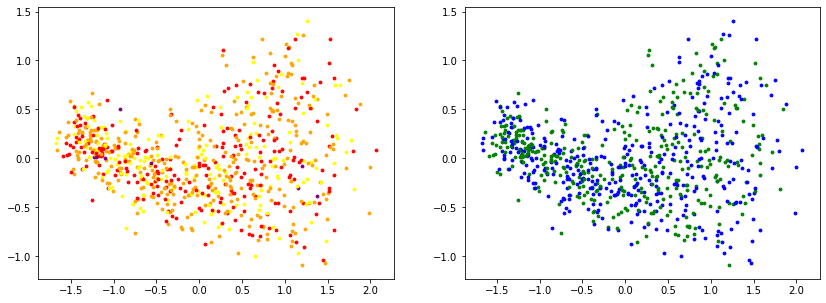

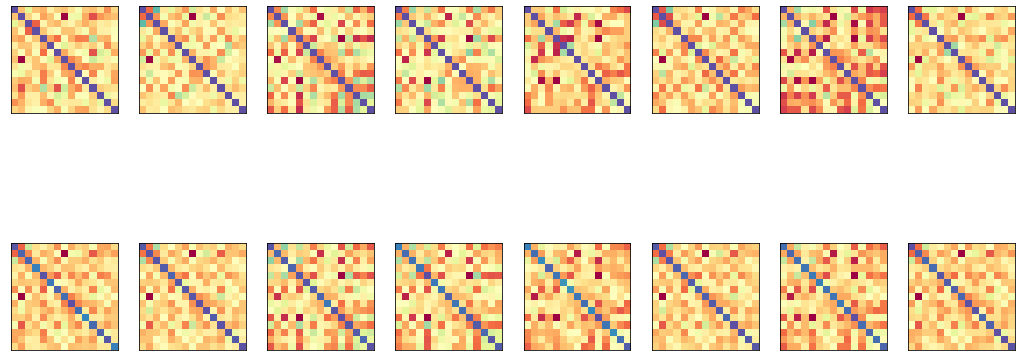

In [34]:
train_dir = 'Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax = axes[0]
im, ax = plot_connectomes_ray(ax, train_dir=train_dir, label_name='Age')

ax = axes[1]
im, ax = plot_connectomes_ray(ax, train_dir=train_dir, label_name='Gender')

show_img_and_recon(train_dir, VAL_DATASET_PATH, cmap=CMAP)

In [35]:
get_unexplained_variance(train_dir, DATASET_PATH)

Loading /neuro/train_val_datasets/train_conn_15x15.npy
Dataset shape: (771, 1, 15, 15)
/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth.
Loading encoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth.
Loading decoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-2

0.6750347492804517

In [173]:
def print_unexplained_variances():
    train_dirs = []
    crits = []
    for train_dir in os.listdir('/home/nina/ray_results/Train/'):
        last_ckpt_path = os.path.join('/home/nina/ray_results/Train', train_dir, 'checkpoint_64')
        if os.path.isdir(last_ckpt_path):
            crit=get_unexplained_variance(train_dir, DATASET_PATH)
            crits.append(crit)
            train_dirs.append(train_dir)
            print('\n')
            print(crit)

In [180]:
print_unexplained_variances()

Loading /neuro/train_val_datasets/train_conn_15x15.npy
Dataset shape: (771, 1, 15, 15)
/home/nina/ray_results/Train/Train_0_batch_size=4,inner_dim=256,latent_dim=2,logvar=-10.0,lr=1e-05,n_layers=4_2019-10-23_15-52-39x0qwjzql/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_0_batch_size=4,inner_dim=256,latent_dim=2,logvar=-10.0,lr=1e-05,n_layers=4_2019-10-23_15-52-39x0qwjzql/checkpoint_64/epoch_64_checkpoint.pth.
Loading encoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_0_batch_size=4,inner_dim=256,latent_dim=2,logvar=-10.0,lr=1e-05,n_layers=4_2019-10-23_15-52-39x0qwjzql/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_0_batch_size=4,inner_dim=256,latent_dim=2,logvar=-10.0,lr=1e-05,n_layers=4_2019-10-23_15-52-39x0qwjzql/checkpoint_64/epoch_64_checkpoint.pth.
Loading decoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_0_batch_size=4



49.42352777871668
Loading /neuro/train_val_datasets/train_conn_15x15.npy
Dataset shape: (771, 1, 15, 15)
/home/nina/ray_results/Train/Train_318_inner_dim=64,latent_dim=5,logvar=-1.0,lr=0.001,n_layers=8_2019-10-23_08-24-19e17iwk9q/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_318_inner_dim=64,latent_dim=5,logvar=-1.0,lr=0.001,n_layers=8_2019-10-23_08-24-19e17iwk9q/checkpoint_64/epoch_64_checkpoint.pth.
Loading encoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_318_inner_dim=64,latent_dim=5,logvar=-1.0,lr=0.001,n_layers=8_2019-10-23_08-24-19e17iwk9q/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_318_inner_dim=64,latent_dim=5,logvar=-1.0,lr=0.001,n_layers=8_2019-10-23_08-24-19e17iwk9q/checkpoint_64/epoch_64_checkpoint.pth.
Loading decoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_318_inner_dim=64,latent_dim=5,logvar=-1.0,lr=0



8.607953091935505
Loading /neuro/train_val_datasets/train_conn_15x15.npy
Dataset shape: (771, 1, 15, 15)
/home/nina/ray_results/Train/Train_96_batch_size=4,inner_dim=32,latent_dim=2,logvar=-5.0,lr=1e-06,n_layers=4_2019-10-23_15-02-31ix20jroi/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_96_batch_size=4,inner_dim=32,latent_dim=2,logvar=-5.0,lr=1e-06,n_layers=4_2019-10-23_15-02-31ix20jroi/checkpoint_64/epoch_64_checkpoint.pth.
Loading encoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_96_batch_size=4,inner_dim=32,latent_dim=2,logvar=-5.0,lr=1e-06,n_layers=4_2019-10-23_15-02-31ix20jroi/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_96_batch_size=4,inner_dim=32,latent_dim=2,logvar=-5.0,lr=1e-06,n_layers=4_2019-10-23_15-02-31ix20jroi/checkpoint_64/epoch_64_checkpoint.pth.
Loading decoder from network of architecture: fc...
/home/nina/ray_results/Train/Trai



1.0296723905886074
Loading /neuro/train_val_datasets/train_conn_15x15.npy
Dataset shape: (771, 1, 15, 15)
/home/nina/ray_results/Train/Train_18_batch_size=4,inner_dim=256,latent_dim=2,logvar=-5.0,lr=1e-05,n_layers=8_2019-10-23_15-22-322s4hg63e/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_18_batch_size=4,inner_dim=256,latent_dim=2,logvar=-5.0,lr=1e-05,n_layers=8_2019-10-23_15-22-322s4hg63e/checkpoint_64/epoch_64_checkpoint.pth.
Loading encoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_18_batch_size=4,inner_dim=256,latent_dim=2,logvar=-5.0,lr=1e-05,n_layers=8_2019-10-23_15-22-322s4hg63e/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_18_batch_size=4,inner_dim=256,latent_dim=2,logvar=-5.0,lr=1e-05,n_layers=8_2019-10-23_15-22-322s4hg63e/checkpoint_64/epoch_64_checkpoint.pth.
Loading decoder from network of architecture: fc...
/home/nina/ray_results/Train



1.0068232418314236
Loading /neuro/train_val_datasets/train_conn_15x15.npy
Dataset shape: (771, 1, 15, 15)
/home/nina/ray_results/Train/Train_51_inner_dim=64,latent_dim=10,logvar=-1.0,lr=0.001,n_layers=4_2019-10-23_07-22-55tefz30eg/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_51_inner_dim=64,latent_dim=10,logvar=-1.0,lr=0.001,n_layers=4_2019-10-23_07-22-55tefz30eg/checkpoint_64/epoch_64_checkpoint.pth.
Loading encoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_51_inner_dim=64,latent_dim=10,logvar=-1.0,lr=0.001,n_layers=4_2019-10-23_07-22-55tefz30eg/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_51_inner_dim=64,latent_dim=10,logvar=-1.0,lr=0.001,n_layers=4_2019-10-23_07-22-55tefz30eg/checkpoint_64/epoch_64_checkpoint.pth.
Loading decoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_51_inner_dim=64,latent_dim=10,logvar=-1.0,lr=

KeyError: 'n_layers'

In [ ]:
#Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic

/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth.
Loading decoder from network of architecture: fc...
/home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth
Found checkpoint. Getting: /home/nina/ray_results/Train/Train_8_inner_dim=256,latent_dim=10,logvar=-10,lr=1e-05,n_layers=4_2019-10-23_13-59-30dqzuemic/checkpoint_64/epoch_64_checkpoint.pth.


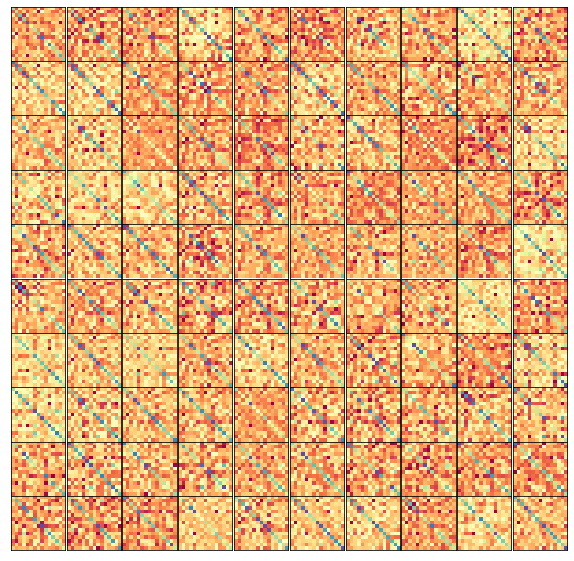

In [115]:
fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(1, 1, wspace=2.3, hspace=2.3)

for i, algo_name in enumerate(['vae']):
    show_samples_from_prior(train_dir, fig, outer, i, cmap=CMAP)
fig.show()